Carlos Garcia - 21000475

In [1]:
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Datos

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

data = np.concatenate((x_train, x_test), axis = 0)
labels = np.concatenate((y_train, y_test), axis = 0)

In [3]:
print(data.shape)
print(labels.shape)

(70000, 28, 28)
(70000,)


In [4]:
labels_dictionary = dict()
labels_dictionary[0] = 'T-shirt/top'
labels_dictionary[1] = 'Trouser'
labels_dictionary[2] = 'Pullover'
labels_dictionary[3] = 'Dress'
labels_dictionary[4] = 'Coat'
labels_dictionary[5] = 'Sandal'
labels_dictionary[6] = 'Shirt'
labels_dictionary[7] = 'Sneaker'
labels_dictionary[8] = 'Bag'
labels_dictionary[9] = 'Ankle boot'

print(labels_dictionary)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [5]:
scaler = StandardScaler()
datanorm = np.array([scaler.fit_transform(img) for img in data])

### Reducir dimensionalidad

In [6]:
def getPCA(data, selection = 'pve', k = 0.8):
    #Calculate eigenvalues and eigenvectors
    x = data.reshape(data.shape[0], -1)
    sigma = np.cov(x.T)
    eigen_values, U = np.linalg.eig(sigma) #values, vectors
    
    #Sort matrix
    ranked_idx = np.argsort(eigen_values)[::-1]
    eigen_values[::-1].sort()
    U = U[ranked_idx]
    
    #Get Proportion of variance explained (PVE)
    pve = eigen_values / sum(eigen_values)
    cumPVE = np.cumsum(pve)

    #Select number of components to use
    if selection == 'pve':
        reduce_idx = np.where(cumPVE >= k)[0][0]
        U_reducida = (U.T[:, :reduce_idx])
    else:
        U_reducida = (U.T[:, :k])
    
    #Get Projected data
    Z = np.matmul(U_reducida.T, x.T).T
    
    #plt.plot(np.cumsum(PVE))
    #plt.plot(PVE)
    
    return Z, pve[0:k]

In [7]:
def getTSNE(data, k):
    x = data.reshape(data.shape[0], -1)
    tsne = TSNE(n_components = k)
    x_embedded = tsne.fit_transform(x)
    return x_embedded

In [8]:
pca_matrix, pve = getPCA(datanorm, 'k', 2)

In [9]:
print("Cantidad de varianza preservada con PCA={}".format(np.abs(pve.cumsum())[-1]))

Cantidad de varianza preservada con PCA=0.22747299171018584


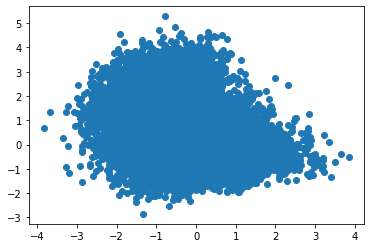

In [10]:
plt.scatter(x = pca_matrix[:, 0].real, y = pca_matrix[:, 1].real)

In [11]:
tsne_matrix = getTSNE(datanorm, 2)

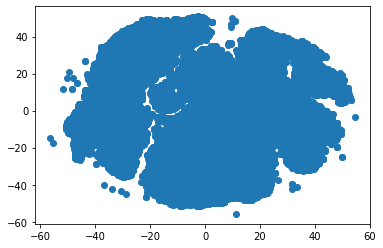

In [12]:
plt.scatter(x = tsne_matrix[:, 0], y = tsne_matrix[:, 1])

#### Conclusiones
- El modelo PCA es computacionalmente más veloz, mientras el modelo T-SNE ocupa más recursos y tiempo
- El modelo T-SNE muestra una escala mayor, por lo cual podemos ver una mayor dispersión entre los datos, en contraste con el modelo PCA

### Clustering

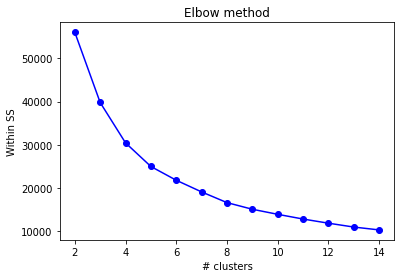

In [14]:
#Elbow method
withinss = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(pca_matrix.real)
    withinss.append(kmeans.inertia_)
    
plt.plot(np.arange(2, 15), withinss, 'o-', color = 'blue')
plt.title('Elbow method')
plt.xlabel('# clusters')
plt.ylabel('Within SS')
plt.show()

Según los resultados obtenidos por el método del codo, se selecciona un k = 5

In [15]:
kmeans_pca = KMeans(n_clusters=5, random_state=0).fit(pca_matrix.real)
kmeans_tsne = KMeans(n_clusters=5, random_state=0).fit(tsne_matrix)

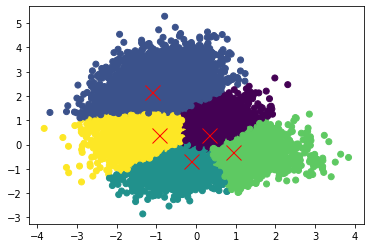

In [16]:
#PCA - Clustering
plt.scatter(x = pca_matrix[:, 0].real, y = pca_matrix[:, 1].real, c = kmeans_pca.labels_)
plt.plot(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], 'rx', markersize = 15)
plt.show()

In [18]:
results = pd.DataFrame({'cluster': kmeans_pca.labels_, 'labels': list(map(labels_dictionary.get, labels)), 'count': np.ones_like(labels)})
results.pivot_table(values = 'count', index = 'cluster', columns = 'labels', aggfunc = np.sum)

labels,Ankle boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
cluster,,,,,,,,,,
0,264.0,1603.0,2801.0,1992.0,2172.0,713.0,2817.0,173.0,3570.0,2162.0
1,323.0,718.0,22.0,43.0,87.0,2244.0,129.0,4939.0,104.0,38.0
2,4875.0,851.0,1545.0,1614.0,2935.0,2466.0,1902.0,370.0,542.0,438.0
3,55.0,579.0,2310.0,2244.0,1174.0,197.0,1443.0,3.0,1960.0,4162.0
4,1483.0,3249.0,322.0,1107.0,632.0,1380.0,709.0,1515.0,824.0,200.0


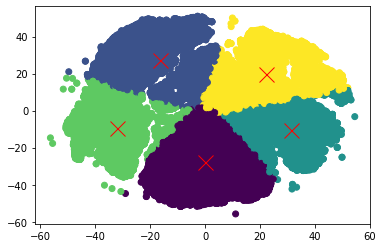

In [17]:
#T-SNE Clustering
plt.scatter(x = tsne_matrix[:, 0], y = tsne_matrix[:, 1], c = kmeans_tsne.labels_)
plt.plot(kmeans_tsne.cluster_centers_[:, 0], kmeans_tsne.cluster_centers_[:, 1], 'rx', markersize = 15)
plt.show()

In [19]:
results = pd.DataFrame({'cluster': kmeans_tsne.labels_, 'labels': list(map(labels_dictionary.get, labels)), 'count': np.ones_like(labels)})
results.pivot_table(values = 'count', index = 'cluster', columns = 'labels', aggfunc = np.sum)

labels,Ankle boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
cluster,,,,,,,,,,
0,NaN,62.0,6181.0,1163.0,5838.0,NaN,3951.0,NaN,79.0,45.0
1,6262.0,21.0,51.0,57.0,4.0,3317.0,16.0,615.0,5.0,4894.0
2,NaN,826.0,96.0,1599.0,636.0,5.0,2027.0,1.0,5681.0,4.0
3,737.0,34.0,448.0,41.0,355.0,3627.0,42.0,6382.0,22.0,485.0
4,1.0,6057.0,224.0,4140.0,167.0,51.0,964.0,2.0,1213.0,1572.0


#### Conclusiones
- No en todos los clusters generados por PCA se realizaron agrupaciones de prendas similares. Sin embargo, en algunos clusters como el cluster 0, es posible ver una clara agrupación pues contiene principalmente las etiquetas (coat, pullover, t-shirt, shirt) siendo todas estas para la parte superior del cuerpo. 
- En el caso de los clusters generados por T-SNE es posible apreciar una mejor agrupación de las distintas prendas dentro de cada cluster, ejemplo de esto es el cluster 0 que agrupa (coat, pullover, shirt), o bien el cluster 3 que agrupa (sandal, sneaker) mostrando una clara agrupación de prendas de la parte superior, como de zapatos. 

### Conclusiones Generales
- En general es importante seleccionar un número de dimensiones adecuado para trabajar, en este caso PCA muetra un 22% de la varianza preservada por lo este valor mejoraría con un mayor número de dimensiones, a su vez teniendo un impacto directo en el modelo de clustering. 
- La reducción de dimensionalidades es una técnica de gran utilidad para mejorar el funcionamiento de otros algoritmos, por lo que es un preprocesamiento útil que en este caso permite pasar de 784 a 2 dimensiones.